In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, dot, Activation, concatenate
from tensorflow.keras import backend as K
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as snsG

In [47]:
# Loading and preprocess the data
data = pd.read_csv('continuous dataset.csv')

In [48]:
# Convert datetime column to datetime object
data['datetime'] = pd.to_datetime(data['datetime'])

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48048 entries, 0 to 48047
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    48048 non-null  datetime64[ns]
 1   nat_demand  48048 non-null  float64       
 2   T2M_toc     48048 non-null  float64       
 3   QV2M_toc    48048 non-null  float64       
 4   TQL_toc     48048 non-null  float64       
 5   W2M_toc     48048 non-null  float64       
 6   T2M_san     48048 non-null  float64       
 7   QV2M_san    48048 non-null  float64       
 8   TQL_san     48048 non-null  float64       
 9   W2M_san     48048 non-null  float64       
 10  T2M_dav     48048 non-null  float64       
 11  QV2M_dav    48048 non-null  float64       
 12  TQL_dav     48048 non-null  float64       
 13  W2M_dav     48048 non-null  float64       
 14  Holiday_ID  48048 non-null  int64         
 15  holiday     48048 non-null  int64         
 16  school 

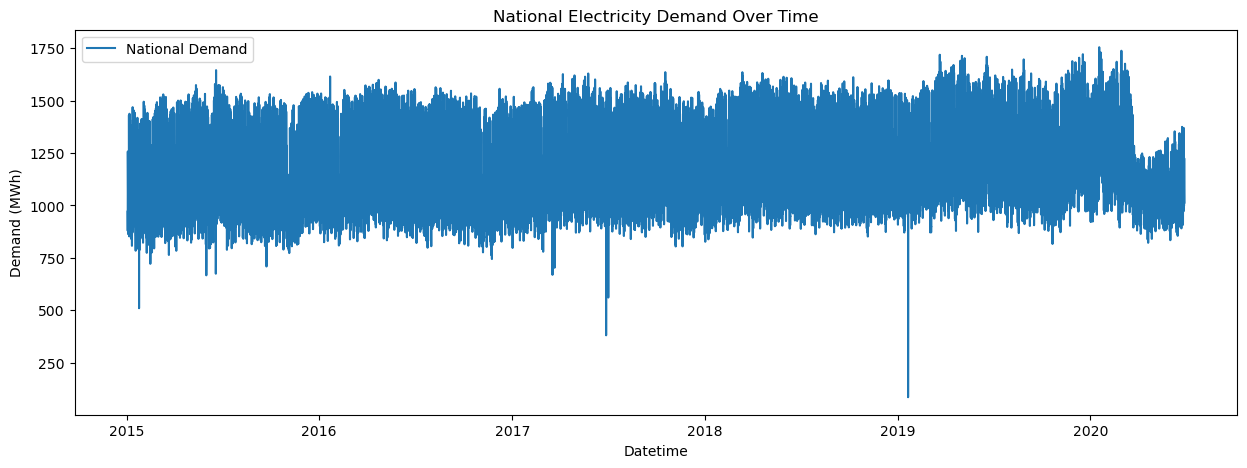

In [49]:
# Exploratory Data Analysis (EDA)
print("Dataset Info:\n")
data.info()

print("\nSummary Statistics:\n")
print(data.describe())

print("\nMissing Values:\n")
print(data.isnull().sum())

# Plot time series of the target variable
plt.figure(figsize=(15, 5))
plt.plot(data['datetime'], data['nat_demand'], label='National Demand')
plt.xlabel('Datetime')
plt.ylabel('Demand (MWh)')
plt.title('National Electricity Demand Over Time')
plt.legend()
plt.show()

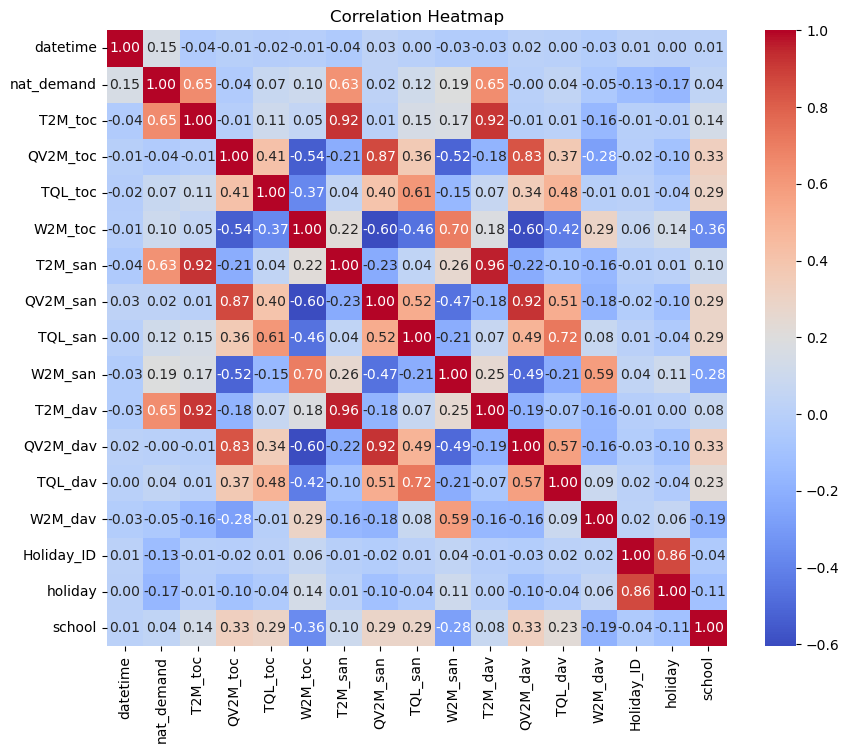

In [50]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [51]:
# Feature engineering: Create time-related features
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek
data['month'] = data['datetime'].dt.month
data['year'] = data['datetime'].dt.year

# Create lag features
for lag in [24, 48, 72, 168]:  # Lagging by hours (1, 2, 3 days and 1 week)
    data[f'nat_demand_lag_{lag}'] = data['nat_demand'].shift(lag)

# Create moving averages
data['nat_demand_ma_24'] = data['nat_demand'].rolling(window=24).mean()
data['nat_demand_ma_168'] = data['nat_demand'].rolling(window=168).mean()

# Drop rows with NaN values due to lagging and rolling operations
data.dropna(inplace=True)

# Scale the data for LSTM
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['nat_demand'] + [col for col in data.columns if 'lag' in col or 'ma' in col]])

# Split into train and test sets
train_size = int(len(data_scaled) * 0.8)
train, test = data_scaled[:train_size], data_scaled[train_size:]

In [52]:
# Prepare LSTM input
X_train, y_train = [], []
X_test, y_test = [], []

# Define a sequence length for LSTM
sequence_length = 168

for i in range(sequence_length, len(train)):
    X_train.append(train[i-sequence_length:i, :])
    y_train.append(train[i, 0])

for i in range(sequence_length, len(test)):
    X_test.append(test[i-sequence_length:i, :])
    y_test.append(test[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Step 2: Build and train the LSTM model with attention mechanism
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_out = LSTM(50, return_sequences=True)(input_layer)
attention = dot([lstm_out, lstm_out], axes=[2, 2])
attention = Activation('softmax')(attention)
context = dot([attention, lstm_out], axes=[2, 1])
combined = concatenate([context, lstm_out])
lstm_out2 = LSTM(50)(combined)
output_layer = Dense(1)(lstm_out2)

lstm_model = Model(inputs=input_layer, outputs=output_layer)
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 121s 98ms/step - loss: 0.0100 - val_loss: 8.0718e-04
Epoch 2/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 119s 100ms/step - loss: 6.7252e-04 - val_loss: 4.5869e-04
Epoch 3/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 118s 99ms/step - loss: 4.5112e-04 - val_loss: 4.2030e-04
Epoch 4/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 119s 100ms/step - loss: 4.5052e-04 - val_loss: 5.9806e-04
Epoch 5/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 119s 99ms/step - loss: 3.9370e-04 - val_loss: 3.7255e-04
Epoch 6/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 120s 100ms/step - loss: 3.7442e-04 - val_loss: 3.0814e-04
Epoch 7/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 120s 101ms/step - loss: 3.3981e-04 - val_loss: 3.1633e-04
Epoch 8/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 119s 100ms/step - loss: 2.8939e-04 - val_loss: 3.4655e-04
Epoch 9/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 121s 101ms/step - loss: 2.8609e-04 - val_loss: 3.2150e-04
Epoch 10/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 119s 100ms/step - loss: 2.2369e-04 - val_loss: 2.7373e-04


In [53]:
# Step 3: Use LSTM predictions as additional features for XGB
lstm_predictions = lstm_model.predict(X_test)

X_xgb = np.hstack((test[sequence_length:, 1:], lstm_predictions))

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_xgb, y_test)

# Step 4: Evaluate the model
predictions = xgb_model.predict(X_xgb)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Additional evaluation metrics
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
peak_error = np.abs(np.max(y_test) - np.max(predictions)) / np.max(y_test) * 100
valley_error = np.abs(np.min(y_test) - np.min(predictions)) / np.min(y_test) * 100
energy_error = np.abs(np.sum(y_test) - np.sum(predictions)) / np.sum(y_test) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"Peak Error: {peak_error}")
print(f"Valley Error: {valley_error}")
print(f"Energy Error: {energy_error}")

294/294 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step
MAE: 0.00045906678855783556
RMSE: 0.0006822748530172007
MAPE: 0.06771468994191283
Peak Error: 1.0560393333435059
Valley Error: 1.1125774367829186
Energy Error: 7.2331354514565594e-06


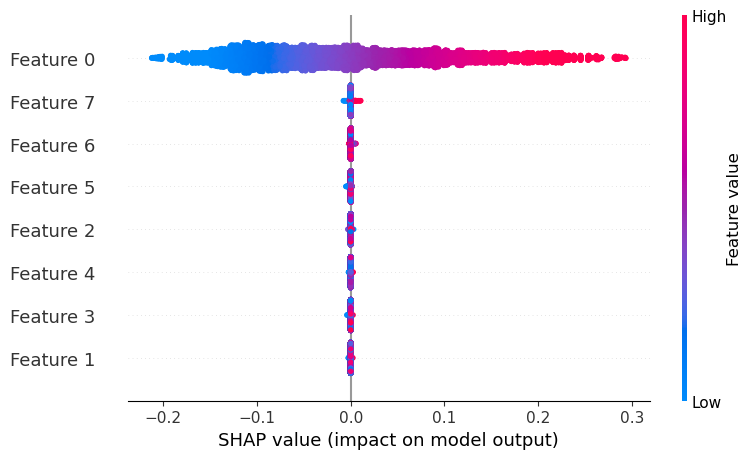

In [54]:
# Step 5: Explain model predictions using SHAP
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_xgb)

# Visualize feature importance
shap.summary_plot(shap_values, X_xgb)